Создание модели для Style transfer
============================
За основу взяты эти работы
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
- Семинар из DLS 2020


`Alexis Jacq <https://alexis-jacq.github.io>` <br />
`Zueva Nadya <https://github.com/nestyme>` <br />
`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.

Введение
------------

В работах, что указаны выше модель строилась автоматически из загруженной модели VGG19. Поскольку конечным заданием является построение телеграм бота, то нужно оптимизировать работу функций, чтобы каждый раз не скачивать заново модель VGG19.



## Импорты

In [2]:
# !pip3 install torch torchvision
# !pip3 install pillow==4.1.1

In [3]:
!ls

images	sample_data


In [4]:
# !mkdir images'all'

In [5]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [6]:
!ls images/

lisa.jpg  picasso.jpg


## Загрузка изображений

Нам понадобятся картинки стиля и контента, так что загрузим их.

Я решил не менять размер картинки контента, а изменить размер картинки стиля под размеры контента. Такой подход может ухудшить качество переноса стиля, но зато конечный пользователь будет получать картинку того размера, что он и загружал.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
def load_two_img(image_name_list):
    assert len(image_name_list) ==2
    size_list = []
    for i,name in enumerate(image_name_list):
        image = Image.open(name)
        size_list += list(image.size)
        image.close()
    imsize = min(size_list)
    loaders = []
    for name in image_name_list:
        image = Image.open(name)
        loaders.append(my_loader(imsize)(image).unsqueeze(0).to(device, torch.float))
        image.close()
    return loaders
def load_two_img_2(image_name_list):
    assert len(image_name_list) ==2
    size_list = []
    for i,name in enumerate(image_name_list):
        image = Image.open(name)
        size_list += list(image.size)
        image.close()
    imsize = min(size_list)
    loaders = []
    for i,name in enumerate(image_name_list):
        image = Image.open(name)
        if i ==1:
            loaders.append(transforms.Compose([transforms.ToTensor()])(image).unsqueeze(0).to(device, torch.float))
        else:
            size = (size_list[3],size_list[2])
            loaders.append(transforms.Compose([transforms.Resize(size),
                                transforms.ToTensor()])(image).unsqueeze(0).to(device, torch.float))
        image.close()
    return loaders

In [9]:
style_img, content_img = load_two_img_2(["images/picasso.jpg", "images/lisa.jpg"])

In [10]:
style_img.size(), content_img.size()

(torch.Size([1, 3, 270, 181]), torch.Size([1, 3, 270, 181]))

Выведем то, что было загружено

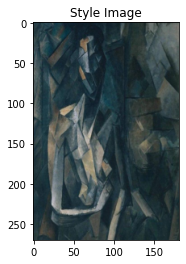

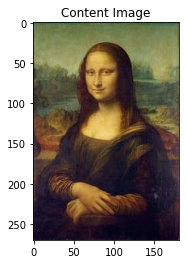

In [11]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Создание модели

Далее идут функции и классы, что были взяты из работ в заголовке.

In [12]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [13]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [14]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [16]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента. Сначала я решил добавить пару слоев для подсчета ошибки, но потом оказалось, что модель не помещается в оперативной памяти, что выделяет heroku. Поэтому я решил вернутся к тому набору слоев, что был изначально в указаных сверху работах.

In [17]:
# content_layers_default = ['conv_4', 'conv_2']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4',
#                         'conv_5', 'conv_6']

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [19]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [20]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [21]:
model, style_losses, content_losses = get_style_model_and_losses(cnn, 
        cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Теперь мы определили модель. Скачаем ее веса в отдельный файл.

In [22]:
params = model.state_dict()

In [23]:
import pickle
with open('model_params.pkl', 'wb') as dfile:
    pickle.dump(params, dfile)

### Новая фиксированная модель

[Тут](https://pytorch.org/tutorials/beginner/saving_loading_models.html) написано, что для загрузки параметров модели из файла, нужен класс модели.

я не придумал ничего лучшего, чем просто руками создать класс модели на основе зафиксированных слоев, в котороых считается ошибка. Также этому классу модели добавлен метод для замены отографий стиля и контента на новые.

In [24]:
class Prepared_Model (nn.Module):
    def __init__(self, normalization_mean, normalization_std):
        super().__init__()
        self.n = Normalization(normalization_mean, normalization_std)
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_2 = nn.ReLU()
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_3 = nn.ReLU()
        self.conv_4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu_4 = nn.ReLU()
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv_5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
    def style_and_content_loss(self,images):
        """
        images -- tensor with 2 images: styke and content
        images size = (2, 3, imsize, imsize)
        """
        style_losses = []
        content_losses = []
        
        images = self.n(images)
        images = self.conv_1(images)
        
        target_feature = images[0].clone().detach()        
        self.style_loss_1 = StyleLoss(target_feature.unsqueeze(0))
        style_losses.append(self.style_loss_1)
                
        images = self.relu_1(images)
        images = self.conv_2(images)
        
        target_feature = images.clone().detach()
        self.style_loss_2 = StyleLoss(target_feature[0].unsqueeze(0))
        style_losses.append(self.style_loss_2)
        self.content_loss_2 = ContentLoss(target_feature[1].unsqueeze(0))
        content_losses.append(self.content_loss_2)
        
        images = self.relu_2(images)
        images = self.pool_2(images)
        images = self.conv_3(images)
        
        target_feature = images[0].clone().detach()        
        self.style_loss_3 = StyleLoss(target_feature.unsqueeze(0))
        style_losses.append(self.style_loss_3)
        
        images = self.relu_3(images)
        images = self.conv_4(images)
        
        target_feature = images.clone().detach()
        self.style_loss_4 = StyleLoss(target_feature[0].unsqueeze(0))
        style_losses.append(self.style_loss_4)
        
        images = self.relu_4(images)
        images = self.pool_4(images)
        images = self.conv_5(images)
        
        target_feature = images[0].clone().detach()        
        self.style_loss_5 = StyleLoss(target_feature.unsqueeze(0))
        style_losses.append(self.style_loss_5)
        
        return style_losses, content_losses

    def forward(self,x):
        x = self.n(x)
        x = self.conv_1(x)
        
        x = self.style_loss_1(x)        
                
        x = self.relu_1(x)
        x = self.conv_2(x)
        
        x = self.content_loss_2(x)
        x = self.style_loss_2(x)
        
        x = self.relu_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        
        x = self.style_loss_3(x)
        
        x = self.relu_3(x)
        x = self.conv_4(x)
        
        x = self.style_loss_4(x)
        
        x = self.relu_4(x)
        x = self.pool_4(x)
        x = self.conv_5(x)
        
        x = self.style_loss_5(x)
        
        return x
        

## Обучение

Теперь попробуем запустить новый класс модели.

In [25]:
images = torch.cat((style_img, content_img))
images.size()

torch.Size([2, 3, 270, 181])

In [26]:
model = Prepared_Model(cnn_normalization_mean, cnn_normalization_std).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [27]:
model.load_state_dict(params)

<All keys matched successfully>

Этой функцией мы задаем модели слои Content_loss, Style_loss под нужные картинки.

In [28]:
style_losses, content_losses = model.style_and_content_loss(images)

In [29]:
len(style_losses), len(content_losses)

(5, 1)

Также я адаптировал функцию обучения под новый класс модели.

In [30]:
def MY_run_style_transfer(model, style_losses, content_losses,cnn, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

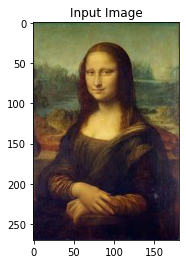

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 3.997572 Content Loss: 2.081100

run [100]:
Style Loss : 0.801825 Content Loss: 1.786170

run [150]:
Style Loss : 0.489755 Content Loss: 1.538360

run [200]:
Style Loss : 0.359323 Content Loss: 1.436132

run [250]:
Style Loss : 0.283576 Content Loss: 1.388282

run [300]:
Style Loss : 0.238133 Content Loss: 1.366744

run [350]:
Style Loss : 0.204748 Content Loss: 1.354439

run [400]:
Style Loss : 0.178326 Content Loss: 1.347318

run [450]:
Style Loss : 0.161243 Content Loss: 1.340558

run [500]:
Style Loss : 0.150626 Content Loss: 1.333565



In [31]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = MY_run_style_transfer(model, style_losses, content_losses,cnn, input_img,)

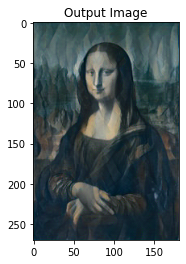

In [32]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Далее нужно сохранить полученное фото.

In [33]:
res = output.permute(0,2,3,1)[0]


In [34]:
res = res.detach()
res.size()

torch.Size([270, 181, 3])

In [35]:
res.max(), res.min()

(tensor(0.8695), tensor(0.))

In [36]:
res = (res*255).byte().numpy()

In [37]:
res.max(), res.min()

(221, 0)

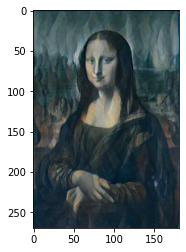

In [38]:
plt.imshow(res)

In [39]:

Img = Image.fromarray(res)

In [40]:
Img.save('test.jpg')